In [34]:
import numpy as np
import matplotlib 
import matplotlib as mpl

import lightkurve 
from lightkurve import KeplerLightCurve, KeplerTargetPixelFile
from k2sc.standalone import k2sc_lc
import k2sc
print(k2sc.__file__)
from astropy.table import Table
from astropy.io import fits

import halophot

import fitsio

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
matplotlib.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

/anaconda3/lib/python3.7/site-packages/K2SC-1.0-py3.7.egg/k2sc/__init__.py
Populating the interactive namespace from numpy and matplotlib


In [9]:
ls ../reduced/c13/

105_Tau_all_tv.png         HR_1427_all_tv.png
105_Tau_halo_lc_tv.fits    HR_1427_halo_lc_tv.fits
11_Ori_all_tv.png          HR_1459_all_tv.png
11_Ori_halo_lc_tv.fits     HR_1459_halo_lc_tv.fits
15_Ori_all_tv.png          HR_1554_all_tv.png
15_Ori_halo_lc_tv.fits     HR_1554_halo_lc_tv.fits
51_Tau_all_tv.png          HR_1576_all_tv.png
51_Tau_halo_lc_tv.fits     HR_1576_halo_lc_tv.fits
53_Tau_all_tv.png          HR_1585_all_tv.png
53_Tau_halo_lc_tv.fits     HR_1585_halo_lc_tv.fits
56_Tau_all_tv.png          HR_1633_all_tv.png
56_Tau_halo_lc_tv.fits     HR_1633_halo_lc_tv.fits
75_Tau_all_tv.png          HR_1684_all_tv.png
75_Tau_halo_lc_tv.fits     HR_1684_halo_lc_tv.fits
80_Tau_all_tv.png          HR_1741_all_tv.png
80_Tau_halo_lc_tv.fits     HR_1741_halo_lc_tv.fits
81_Tau_all_tv.png          HR_1755_all_tv.png
81_Tau_halo_lc_tv.fits     HR_1755_halo_lc_tv.fits
85_Tau_all_tv.png          del3_Tau_all_tv.png
85_Tau_halo_lc_tv.fits     del3_Tau_halo_lc_tv.fits
89_Tau_all_tv.png          e

In [11]:
campaign = 13
ddir = '../reduced/c%d/'% campaign
starname = 'Aldebaran'
fname = ddir+'%s_halo_lc_tv.fits' % starname.replace(' ','_')

f = fitsio.FITS(fname)
hdr = fitsio.read_header(fname)
if campaign in [91,92, 101, 102, 111, 112]:
    campaign_name = int(str(campaign)[:-1])
else:
    campaign_name = campaign

all_stars = Table.read('../data/haloC%d.csv' % campaign_name,format='ascii')
star = all_stars[all_stars['Name']==starname]
epic = star['EPIC ID'].data.data[0]
star

Name,Vmag,Sp. Type,EPIC ID,RA (J2000) [deg],Dec (J2000) [deg],MASK,Investigation IDs,LC TPF,Project,Contact,Publication,Comments
str9,float64,str12,int64,float64,float64,str7,str109,str17,str13,str9,str15,str33
Aldebaran,0.86,K5III,200173843,68.980934,16.509007,LC Halo,GO13047_LC,KTWO200173843-C13,Aldebaran,Farr/Pope,Farr et al 2018,\citet{Farr2018}


In [12]:
def match_cadences(halocads,lccads):
    indices =np.array([1 if j in lccads else 0 for j in halocads])
    return np.where(indices==1)[0]



In [13]:
tpf = lightkurve.open('../data/ktwo%d-c%02d_lpd-targ.fits.gz' % (epic,campaign))
lc = tpf.to_lightcurve('aperture')
lc.pos_corr1 = tpf.pos_corr1
lc.pos_corr2 = tpf.pos_corr2
lc.primary_header = tpf.hdu[0].header
lc.data_header = tpf.hdu[1].header

inds_lc = match_cadences(lc.cadenceno,f[1]['cadence'][:])
lc = lc[inds_lc]
lc.pos_corr1 = lc.pos_corr1[inds_lc]
lc.pos_corr2 = lc.pos_corr2[inds_lc]


inds_flux = match_cadences(f[1]['cadence'][:],lc.cadenceno)
lc.flux = f[1]['corr_flux'][inds_flux]

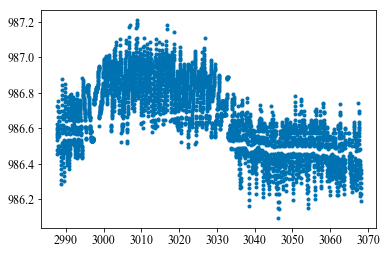

In [14]:
plt.plot(lc.time,lc.centroid_col,'.')
# plt.axvline(2830)
# plt.axvline(3367)
# plt.axvline(3400)

In [15]:
# now the magic happens
lc.__class__ = k2sc_lc

In [16]:
lc.k2sc()

Using default splits [2998, 3033] for campaign 13
Starting initial outlier detection
  Flagged 0 ( 0.0%) outliers.
Starting Lomb-Scargle period search
  Using SqrExp position kernel
  Found periodicity p =    5.75 (fap 2.0522e-180 < 1e-50), will use a quasiperiodic kernel
Starting global hyperparameter optimisation using DE
  DE iteration %3i -ln(L) %4.1f 0 -5317.174909589341
  DE iteration %3i -ln(L) %4.1f 1 -5352.04890879965
  DE iteration %3i -ln(L) %4.1f 2 -5354.256619315047
  DE iteration %3i -ln(L) %4.1f 3 -5411.599996071194
  DE iteration %3i -ln(L) %4.1f 4 -5418.608495679513
  DE iteration %3i -ln(L) %4.1f 5 -5418.608495679513
  DE iteration %3i -ln(L) %4.1f 6 -5434.478932257886
  DE iteration %3i -ln(L) %4.1f 7 -5434.478932257886
  DE iteration %3i -ln(L) %4.1f 8 -5434.478932257886
  DE iteration %3i -ln(L) %4.1f 9 -5434.478932257886
  DE iteration %3i -ln(L) %4.1f 10 -5434.478932257886
  DE iteration %3i -ln(L) %4.1f 11 -5434.478932257886
  DE iteration %3i -ln(L) %4.1f 12 -5

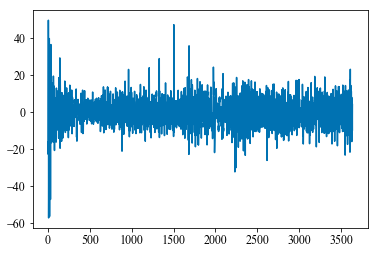

In [17]:
plt.plot(lc.corr_flux-lc.tr_time)

In [18]:
lc.tr_position

array([70581.05397342, 70602.56909467, 70628.1523793 , ...,
       70577.22709248, 70563.03769432, 70549.01650871])

In [19]:
lc.__dict__.keys()

dict_keys(['time', 'flux', 'flux_err', 'time_format', 'time_scale', 'targetid', 'label', 'meta', 'centroid_col', 'centroid_row', 'quality', 'cadenceno', 'quality_bitmask', 'channel', 'campaign', 'quarter', 'mission', 'ra', 'dec', 'pos_corr1', 'pos_corr2', 'primary_header', 'data_header', 'tr_position', 'tr_time', 'pv', 'corr_flux'])

In [20]:
to_save = ['time', 'flux', 'flux_err','centroid_col', 'centroid_row', 'quality', 'cadenceno','pos_corr1', 'pos_corr2','tr_position', 'tr_time','corr_flux']

dummy = fits.getheader('../data/ktwo%d-c%02d_lpd-targ.fits.gz' % (epic,campaign))
dummy['NAXIS']=1
dummy['halo'] =(halophot.__version__,'halophot version')
dummy['order']=(1,'halophot TV order')
dummy['sub']=(1,'halophot subsampling')
dummy['starname']=(starname,'Star Identifier')

hdu = fits.PrimaryHDU(f[0][:,:],dummy) # can't save a masked array yet so just using pixelmap
cols = [fits.Column(name=key,format="D",array=lc.__dict__[key]) for key in to_save]
tab = fits.BinTableHDU.from_columns(cols)


hdul = fits.HDUList([hdu, tab])
hdul.writeto('%s_%s_halo_k2sc.fits' % (starname,epic),overwrite=True)


In [21]:
dummy

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    1 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2018-06-06'         / file creation date.                            
CREATOR = '518403 TargetPixelExporterPipelineModule' / pipeline job and program 
PROCVER = 'svn+ssh://murzim/repo/soc/tags/release/9.3.89 r63269' / SW version   
FILEVER = '6.1     '           / file format version                            
TIMVERSN= 'OGIP/93-003'     

In [38]:
from halophot.halo_tools import *

def plot_fluxmap(ax1,image,name,title=False):

        cmap = mpl.cm.hot
        cmap.set_bad('k',1.)
        im = np.log10(image)
        pic = ax1.imshow(im,cmap=cmap, vmax=np.nanmax(im),
            interpolation='nearest',origin='lower')
        if title:
            plt.title(r'%s Flux Map' % name)

        aspect = 20
        pad_fraction = 0.5

        divider = make_axes_locatable(ax1)
        width = axes_size.AxesY(ax1, aspect=1./aspect)
        pad = axes_size.Fraction(pad_fraction, width)
        cax = divider.append_axes("left", size=width, pad=pad)
        plt.colorbar(pic, cax=cax)

        ax1.yaxis.set_ticks_position('right')
        
        cax.yaxis.set_ticks_position('left')
        
def plot_weightmap(ax1,weightmap,name,title=False):
        norm = np.size(weightmap)

        cmap = mpl.cm.seismic
        cmap.set_bad('k',1.)

        im = np.log10(weightmap.T*norm)
        pic = ax1.imshow(im,cmap=cmap, vmin=-2*np.nanmax(im),vmax=2*np.nanmax(im),
            interpolation='nearest',origin='lower')
        if title:
            plt.title(r'TV-min Weightmap %s' % name)

        # cbaraxes, kw = mpl.colorbar.make_axes(ax1,location='right',pad=0.01)
        # plt.colorbar(pic,cax=cbaraxes)

        # cbaraxes.yaxis.set_ticks_position('right')
        aspect = 20
        pad_fraction = 0.5

        divider = make_axes_locatable(ax1)
        width = axes_size.AxesY(ax1, aspect=1./aspect)
        pad = axes_size.Fraction(pad_fraction, width)
        cax = divider.append_axes("right", size=width, pad=pad)
        plt.colorbar(pic, cax=cax)

        ax1.yaxis.set_ticks_position('left')

def plot_k2sc(lc,image,weightmap,save_file=None,formal_name='test'):
    min_p,max_p=1./24.,20.

    PW,PH = 8.27, 11.69
    
    frequency, power, spower = get_pgram(lc.time,lc.corr_flux-lc.tr_time,min_p=min_p,max_p=max_p)
    
    rc('axes', labelsize=7, titlesize=8)
    rc('font', size=6)
    rc('xtick', labelsize=7)
    rc('ytick', labelsize=7)
    rc('lines', linewidth=1)
    fig = plt.figure(figsize=(PW,PH))
    gs1 = GridSpec(3,2)
    gs1.update(top=0.95, bottom = 2/3.*1.05,hspace=0.0,left=0.09,right=0.96)
    gs2 = GridSpec(1,2)
    gs2.update(top=2/3.*0.97,bottom=1/3.*1.07,hspace=0.35,left=0.09,right=0.96)
    gs3 = GridSpec(2,2)
    gs3.update(top=1/3.*0.96,bottom=0.04,hspace=0.07,left=0.09,right=0.96)

    ax_lctime = subplot(gs1[0,:])
    ax_lcpos = subplot(gs1[1,:],sharex=ax_lctime)
    ax_lcwhite = subplot(gs1[2,:],sharex=ax_lctime)
    ax_fluxmap = subplot(gs2[0,0])
    ax_weightmap = subplot(gs2[0,1])
    ax_periodogram   = subplot(gs3[0,:])
    ax_logpgram    = subplot(gs3[1,:])

    plot_lc(ax_lctime,lc.time,lc.flux-lc.tr_time+np.nanmedian(lc.tr_time),formal_name,trend=lc.tr_position)
    plot_lc(ax_lcpos,lc.time,lc.flux-lc.tr_position+np.nanmedian(lc.tr_position),formal_name,trend=lc.tr_time)
    plot_lc(ax_lcwhite,lc.time,lc.corr_flux-lc.tr_time,formal_name+': Whitened')
    plot_weightmap(ax_weightmap,weightmap,formal_name)
    plot_fluxmap(ax_fluxmap,image,formal_name)
    plot_pgram(ax_periodogram,frequency,power,spower,formal_name)        
    plot_log_pgram(ax_logpgram,frequency,power,spower,formal_name)  

    fig.suptitle(formal_name+' Detrended',y=0.99,fontsize=20)
    ax_periodogram.set_title('Periodograms')
    ax_fluxmap.set_title('Flux Map')
    ax_weightmap.set_title('TV-Min Weight Map')

    if save_file is not None:
        plt.savefig(save_file,bbox_inches='tight')
        
def plot_lc(ax1,time,lc,name,trend=None,title=False):
        m = (lc>0.) * (np.isfinite(lc))

        ax1.plot(time[m],lc[m]/np.nanmedian(lc[m]),'.')
        dt = np.nanmedian(time[m][1:]-time[m][:-1])
        ax1.set_xlim(time[m].min()-dt,time[m].max()+dt)
        if trend is not None:
            ax1.plot(time[m],trend[m]/np.nanmedian(trend[m]),'-',color=colours[2])
            plt.legend(labels=['Flux','Trend'])
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Relative Flux')
        if title:
            plt.title(r'%s' % name)

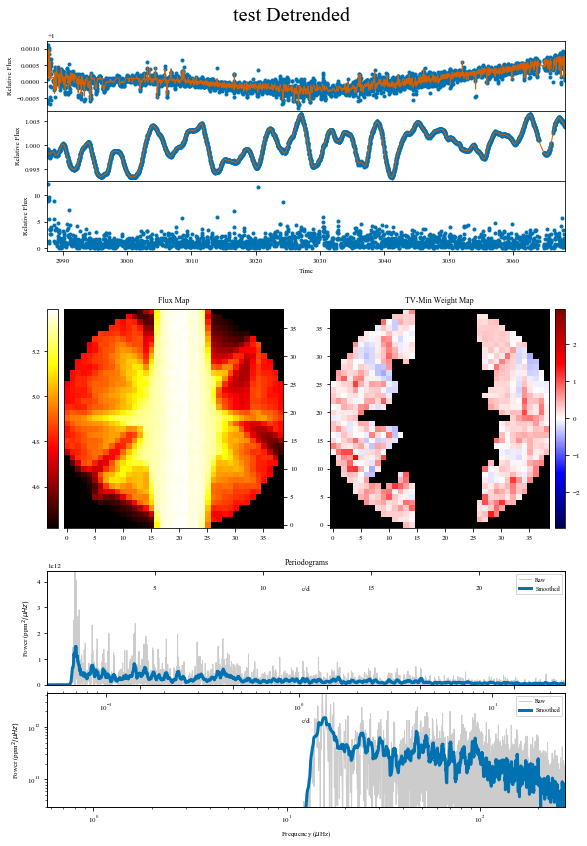

In [39]:
plot_k2sc(lc,np.nanmean(tpf.flux,axis=0),f[0][:,:].T,save_file='test.pdf')